Exercise 5
==========

In [1]:
import numpy
from matplotlib import pyplot
% matplotlib inline

In [2]:
import os, sys
sys.path.append(os.path.split(os.path.split(os.getcwd())[0])[0])

In [3]:
import utils.grids.one_d as assembly
#from utils.quadrature import GaussLobattoJacobi
import utils.quadrature.GaussJacobi as GaussLobattoJacobi

In [4]:
import warnings
warnings.filterwarnings('error')

Consider the following problem:

$$
\frac{d^2 u}{d x^2} - \lambda u = f
$$

where $x$ is defined as $x \in [-1, 1]$. The weak form with test function $\nu$ before lifting is

$$
\int_{-1}^{1}\frac{d\nu}{dx}\frac{du}{dx} dx + 
\lambda\int_{-1}^{1}\nu u dx =
\nu(1)\frac{du}{dx}(1) - 
\nu(-1)\frac{du}{dx}(-1) -
\int_{-1}^{1} \nu f dx
$$

For continuous Galerkin method, the matrix form of the problem is:

$$
\left(\mathbb{L} + \lambda\mathbb{M}\right)\mathbf{u} = - \mathbf{f} + \mathbf{BC_N}
$$

$\mathbf{BC_N}$ represents Newmann type boundary conditions, and 

$$
\mathbf{BC_N} =
\left\{
\begin{array}{ll}
\left.-\frac{du}{dx}\right|_{x=-1} & \text{, if i represents the node }x=-1 \\
\left.\frac{du}{dx}\right|_{x=1} & \text{, if i represents the node }x=1 \\
0 & \text{, else}
\end{array}
\right.
$$

If any Dirchlet BC is given at any boundary point,
then $\frac{du}{dx}$ is normally unknown at that point.
However, after lifting the problem,
the unknown $\frac{du}{dx}$ are eliminated.
So those unknown $\frac{du}{dx}$ will not show up in the matrix system.

Here we define some wrapper functions first for our convenience.

In [5]:
def solve(N, P, f, uBCs, duBCs, ends=[-1, 1]):
    """solvie Helmholts PDE"""
    
    g = assembly.DecomposeAssembly(N, ends, "CommonJacobi", P)
    
    rhs = - g.weak_rhs(f)
    A = g.wL + g.M

    rhs -= A[:, g.l2g[0][0]].A.flatten() * uBCs[0]
    rhs -= A[:, g.l2g[-1][-1]].A.flatten() * uBCs[1]
    
    A = numpy.delete(A, [g.l2g[0][0], g.l2g[-1][-1]], 0)
    A = numpy.delete(A, [g.l2g[0][0], g.l2g[-1][-1]], 1)
    rhs = numpy.delete(rhs, [g.l2g[0][0], g.l2g[-1][-1]])
    
    ui = numpy.linalg.solve(A, rhs)
    ui = numpy.insert(ui, g.l2g[0][0], uBCs[0])
    ui = numpy.insert(ui, g.l2g[-1][-1], uBCs[1])
    g.set_coeffs(ui)
    
    return g

In [6]:
def H1(g, exact, d_exact, l):
    """calculate energy (H1) norm"""
    
    qd = GaussLobattoJacobi(16)
    ans = 0
    for e in g.elems:
        f = lambda x: (e.derivative(x) - d_exact(x))**2 + (e(x) - exact(x))**2
        ans += numpy.sqrt(qd(f, xmin=e.ends[0], xMax=e.ends[1]))
    return ans / numpy.sqrt(l)

In [7]:
def exercise_wrapper(N, P, f, exact, d_exact, ends=[-1, 1]):
    """exercise wrapper"""
    
    Ndof_N = numpy.zeros_like(N, dtype=numpy.int)
    err_N = numpy.zeros_like(N, dtype=numpy.float64)
    Ndof_P = numpy.zeros_like(P, dtype=numpy.int)
    err_P = numpy.zeros_like(P, dtype=numpy.float64)
    
    for i, Ni in enumerate(N):
        g = solve(Ni, 1, f, [exact(ends[0]), exact(ends[1])], [None, None], ends)
        Ndof_N[i] = g.nModes - 2  # values on two boundary nodes are know
        err_N[i] = H1(g, exact, d_exact, ends[1]-ends[0])
        
    for i, Pi in enumerate(P):
        g = solve(2, Pi, f, [exact(ends[0]), exact(ends[1])], [None, None], ends)
        Ndof_P[i] = g.nModes - 2  # values on two boundary nodes are know
        err_P[i] = H1(g, exact, d_exact, ends[1]-ends[0])
        
    return Ndof_N, err_N, Ndof_P, err_P

## Case 1

Now we consider a all-Dirichlet BCs case (with $\lambda=1$):

$$
f(x) = -(\pi^2 + \lambda)\sin(\pi x)
$$

where the exact solution is $u(x) = \sin(\pi x)$

Plot the convergence order for both h- and p-type expansion.

In [8]:
N = numpy.array([2 + 4 * i for i in range(25)])
P = numpy.array([1, 3, 5, 7, 9, 11, 13, 15])

f = lambda x: - (1 + numpy.pi * numpy.pi) * numpy.sin(numpy.pi * x)
exact = lambda x: numpy.sin(numpy.pi * x)
d_exact = lambda x: numpy.pi * numpy.cos(numpy.pi * x)

Ndof_N, err_N, Ndof_P, err_P = exercise_wrapper(N, P, f, exact, d_exact)

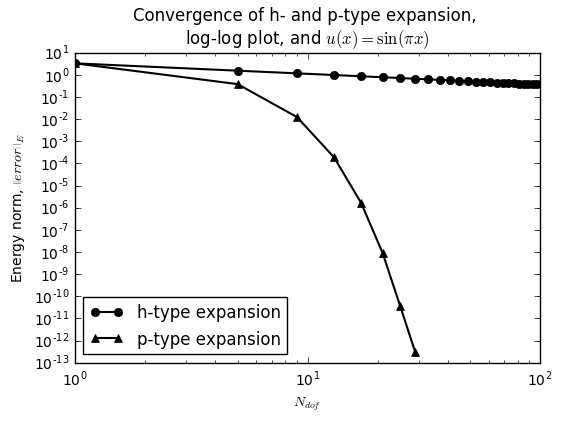

In [9]:
pyplot.loglog(Ndof_N, err_N, 'ko-', lw=1.5, label="h-type expansion")
pyplot.loglog(Ndof_P, err_P, 'k^-', lw=1.5, label="p-type expansion")
pyplot.title("Convergence of h- and p-type expansion, \nlog-log plot, and " + 
             r"$u(x)=\sin(\pi x)$")
pyplot.xlabel(r"$N_{dof}$")
pyplot.ylabel(r"Energy norm, $\left|\left|error\right|\right|_E$")
pyplot.legend(loc=0);

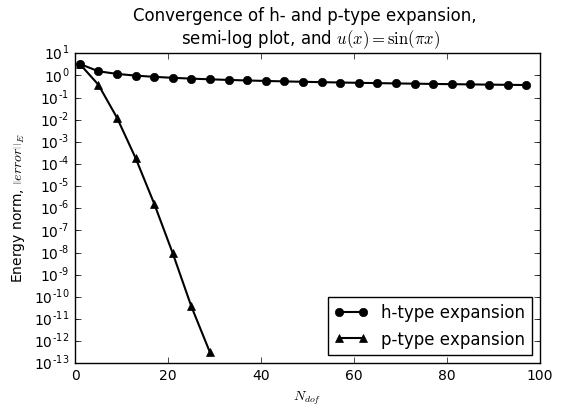

In [10]:
pyplot.semilogy(Ndof_N, err_N, 'ko-', lw=1.5, label="h-type expansion")
pyplot.semilogy(Ndof_P, err_P, 'k^-', lw=1.5, label="p-type expansion")
pyplot.title("Convergence of h- and p-type expansion, \n semi-log plot, and " + 
             r"$u(x)=\sin(\pi x)$")
pyplot.xlabel(r"$N_{dof}$")
pyplot.ylabel(r"Energy norm, $\left|\left|error\right|\right|_E$")
pyplot.legend(loc=0);

## Case 2

Now we consider cases with non-smooth exact solutions: $u(x) = x^{\alpha}$, where $\alpha=0.6,\ 0.9,\ 1.2$. And the right-hand-side will be $f(x) = \alpha(\alpha-1)x^{\alpha-2}-x^{\alpha}$. We still use all-Dirichlet BCs here.

Plot the convergence order for both h- and p-type expansion.

In [11]:
N = numpy.array([2 + 4 * i for i in range(25)])
P = numpy.array([1, 3, 5, 7, 9, 11, 13, 15])

Alpha = [0.6, 0.9, 1.2]
Ndof = numpy.empty((2, 3), dtype=numpy.ndarray)
err = numpy.empty((2, 3), dtype=numpy.ndarray)

for i, alpha in enumerate(Alpha):
    exact = lambda x: x**alpha
    d_exact = lambda x: alpha * (x**(alpha-1))
    f = lambda x: alpha * (alpha - 1) * (x**(alpha-2)) - x**alpha

    Ndof[0][i], err[0][i], Ndof[1][i], err[1][i] = \
        exercise_wrapper(N, P, f, exact, d_exact, [0., 1])

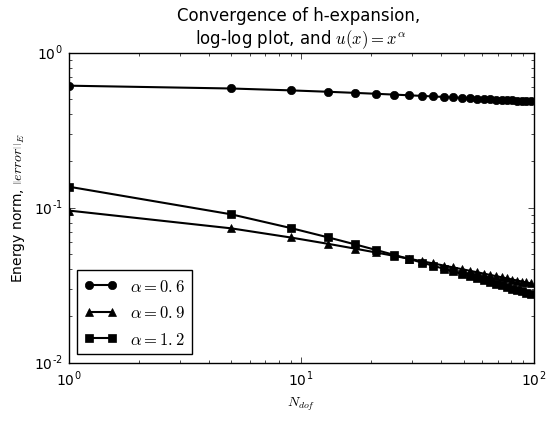

In [12]:
pyplot.loglog(Ndof[0][0], err[0][0], 'ko-', lw=1.5, label=r"$\alpha=0.6$")
pyplot.loglog(Ndof[0][1], err[0][1], 'k^-', lw=1.5, label=r"$\alpha=0.9$")
pyplot.loglog(Ndof[0][2], err[0][2], 'ks-', lw=1.5, label=r"$\alpha=1.2$")
pyplot.title("Convergence of h-expansion, \nlog-log plot, and " + 
             r"$u(x)=x^{\alpha}$")
pyplot.xlabel(r"$N_{dof}$")
pyplot.ylabel(r"Energy norm, $\left|\left|error\right|\right|_E$")
pyplot.legend(loc=0);

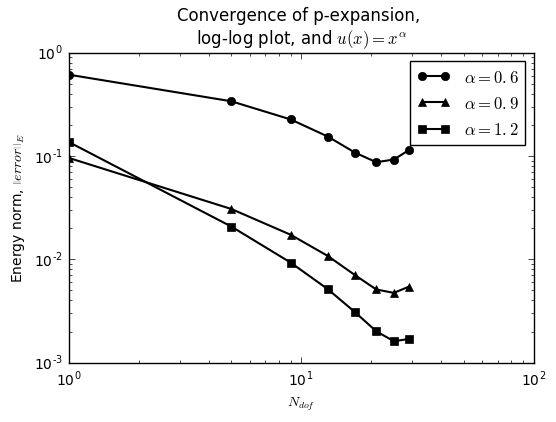

In [13]:
pyplot.loglog(Ndof[1][0], err[1][0], 'ko-', lw=1.5, label=r"$\alpha=0.6$")
pyplot.loglog(Ndof[1][1], err[1][1], 'k^-', lw=1.5, label=r"$\alpha=0.9$")
pyplot.loglog(Ndof[1][2], err[1][2], 'ks-', lw=1.5, label=r"$\alpha=1.2$")
pyplot.title("Convergence of p-expansion, \nlog-log plot, and " + 
             r"$u(x)=x^{\alpha}$")
pyplot.xlabel(r"$N_{dof}$")
pyplot.ylabel(r"Energy norm, $\left|\left|error\right|\right|_E$")
pyplot.legend(loc=0);